In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install praw

In [ ]:
!pip install prawcore

In [ ]:
!pip install emoji

In [ ]:
!pip install -q nltk transformers textblob

In [ ]:
! pip install vaderSentiment

In [ ]:
!pip install numpy==1.26.4 --quiet

In [ ]:
! pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


# Web Scraping - REDDIT using PRAW

setting limit to crawl 100 posts per search terms

In [ ]:
#  Add your Reddit API credentials here (or set as env vars)
REDDIT_CLIENT_ID = 'y3h5X9SacEDwC-uL8sQFwQ'
REDDIT_CLIENT_SECRET = 'jEpcfFVGCmjm29a5Z-I4045P1kIT5A'
REDDIT_USER_AGENT = 'EVSentimentAnalysisBot by /u/EzNameGG'

#  Initialize Reddit API with async warning suppressed
reddit = praw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=REDDIT_USER_AGENT,
    check_for_async=False
)

#  Search terms
search_terms = [
    'ev', 'electric vehicle', 'electric car', 'tesla', 'charging station',
    'byd', 'ora good cat', 'EV infrastructure', 'EV subsidy', 'ev experience', 'ev issues'
]
subreddit = reddit.subreddit('Malaysia')

#  Prepare CSV file
csv_file = 'ev_sentiment_data_new2.csv'
with open(csv_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow([
        'post_id', 'title', 'selftext', 'post_score', 'upvote_ratio',
        'num_comments', 'post_created_utc',
        'comment_id', 'comment_body', 'comment_score',
        'comment_awards', 'comment_created_utc'
    ])

    #  Loop through search terms
    for i, term in enumerate(search_terms):
        print(f"\n🔍 Searching for: {term}")
        try:
            for submission in subreddit.search(term, limit=100):
                print(f" Processing post: {submission.title[:60]}...")

                try:
                    submission.comments.replace_more(limit=None)
                except Exception as e:
                    print(f" Error expanding comments: {e}")
                    continue

                for comment in submission.comments.list():
                    if not isinstance(comment, Comment):
                        continue

                    writer.writerow([
                        submission.id,
                        submission.title,
                        submission.selftext,
                        submission.score,
                        submission.upvote_ratio,
                        submission.num_comments,
                        submission.created_utc,
                        comment.id,
                        comment.body.replace('\n', ' ').strip(),
                        comment.score,
                        comment.total_awards_received,
                        comment.created_utc
                    ])


        except ResponseException as e:
            if hasattr(e, 'response') and e.response.status_code == 429:
                print(" Hit rate limit (HTTP 429). Sleeping for 60 seconds.")
                time.sleep(60)
            else:
                print(f" Unexpected error: {e}")
                continue
        except requests.exceptions.HTTPError as e:
            print(f" HTTP error: {e}. Sleeping 60 seconds.")
            time.sleep(60)
        except Exception as e:
            print(f" Other error: {e}")
            continue

        # 💤 Sleep between terms to avoid search rate limit
        print("⏸ Waiting 60 seconds before next search term...")
        time.sleep(60)

print(f"\n= Done! Data saved to {csv_file}")


🔍 Searching for: ev
📄 Processing post: What are your thoughts on EV owners using public electrical ...
📄 Processing post: Are EV cars practical in Malaysia?...
📄 Processing post: Say hello to EV plat number...
📄 Processing post: Proton reveals their EV sub-brand, e.MAS...
📄 Processing post: if someone usually drive 280km everyday for 7 days a week— w...
📄 Processing post: In the battle of the EVs, BYD is whacking Tesla / BMW so far...
📄 Processing post: First road-legal articulated EV bus in Malaysia is now in op...
📄 Processing post: Malaysia’s EV sales stuck in the slow lane amid high costs, ...
📄 Processing post: In its first month on the market, Proton e.MAS 7 shot to the...
📄 Processing post: Netizens Slam Road Tax Cuts For Malaysia's EV Owners As "Dis...
📄 Processing post: PMX drove Erdogan to Seri Perdana in a Turkish made EV...
📄 Processing post: China’s current best-selling EV is the Geely Xingyuan – Prot...
📄 Processing post: By 2050, 870,000 EV batteries will need recycling

In [ ]:
import shutil
drive_path = '/content/drive/MyDrive/Colab_Notebooks/Research_data/ev_sentiment_data_new2.csv'
shutil.copy('ev_sentiment_data_new2.csv', drive_path)
print(f"✅ File also copied to Google Drive: {drive_path}")

FileNotFoundError: [Errno 2] No such file or directory: 'ev_sentiment_data_new2.csv'

In [ ]:
import pandas as pd
import numpy as np
import emoji
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pyarrow as pa

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import pipeline

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer
from transformers import DataCollatorWithPadding
from datasets import Dataset

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Visualize the scraped data

In [ ]:
dir = '/content/drive/MyDrive/Colab_Notebooks/Research_data/ev_sentiment_data_new2.csv'
ev_new_data2 = pd.read_csv(dir)
ev_new_data2

,post_id,title,selftext,post_score,upvote_ratio,num_comments,post_created_utc,comment_id,comment_body,comment_score,comment_awards,comment_created_utc
0,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,1.676562e+09,j8se6pf,EV owners when they find an unattended electri...,546,0,1.676566e+09
1,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,1.676562e+09,j8twbf7,Apparently some electric cars have battery cap...,211,0,1.676587e+09
2,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,1.676562e+09,j8uhyyh,Imagine if I set up a bitcoin mining rig here....,127,0,1.676596e+09
3,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,1.676562e+09,j8s4nfc,That's gonna be one really slow charge. Probab...,383,0,1.676563e+09
4,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,1.676562e+09,j8sn4cg,It’s amazing how many people here feel that it...,253,0,1.676570e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
43652,17pmdxp,"New structure to lower taxes for EVs, says Loke",NaN,4,0.83,5,1.699332e+09,k86uwol,Yesssssssssssss make EV affordable,3,0,1.699346e+09
43653,17pmdxp,"New structure to lower taxes for EVs, says Loke",NaN,4,0.83,5,1.699332e+09,k88l2nx,i just had to spent loads just to buy batterie...,1,0,1.699378e+09
43654,17pmdxp,"New structure to lower taxes for EVs, says Loke",NaN,4,0.83,5,1.699332e+09,k8mhej8,I highly doubt it will be affordable for anyon...,1,0,1.699607e+09
43655,17pmdxp,"New structure to lower taxes for EVs, says Loke",NaN,4,0.83,5,1.699332e+09,k8b6goz,"Hi there, I doubt your blackouts followed by p...",0,0,1.699414e+09


In [ ]:
ev_new_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43657 entries, 0 to 43656
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   post_id              43657 non-null  object 
 1   title                43657 non-null  object 
 2   selftext             31932 non-null  object 
 3   post_score           43657 non-null  int64  
 4   upvote_ratio         43657 non-null  float64
 5   num_comments         43657 non-null  int64  
 6   post_created_utc     43657 non-null  float64
 7   comment_id           43657 non-null  object 
 8   comment_body         43657 non-null  object 
 9   comment_score        43657 non-null  int64  
 10  comment_awards       43657 non-null  int64  
 11  comment_created_utc  43657 non-null  float64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [ ]:
df_selftext = ev_new_data2[ev_new_data2['selftext'].notnull() & (ev_new_data2['selftext'].str.strip() != '')]

# View top 10 rows
df_selftext[['title', 'selftext', 'comment_body']].iloc[1:10]

,title,selftext,comment_body
350,Are EV cars practical in Malaysia?,"Personally, I don't see that many chargers in ...",Not in a country with some of the cheapest pet...
351,Are EV cars practical in Malaysia?,"Personally, I don't see that many chargers in ...","It really depends on who u ask, for those who ..."
352,Are EV cars practical in Malaysia?,"Personally, I don't see that many chargers in ...",It is practical if you're staying at landed pr...
353,Are EV cars practical in Malaysia?,"Personally, I don't see that many chargers in ...","For today, it is practical for super-urban are..."
354,Are EV cars practical in Malaysia?,"Personally, I don't see that many chargers in ...",I just don’t get the hate on EVs. It’s like th...
355,Are EV cars practical in Malaysia?,"Personally, I don't see that many chargers in ...",Maybe in 10 years time.
356,Are EV cars practical in Malaysia?,"Personally, I don't see that many chargers in ...","Yeah, the country is pretty small that if a pe..."
357,Are EV cars practical in Malaysia?,"Personally, I don't see that many chargers in ...","I say no. Tech still too new, charging station..."
358,Are EV cars practical in Malaysia?,"Personally, I don't see that many chargers in ...",Still a rich man toy


In [ ]:
print("Total posts:", len(ev_new_data2))
print("Posts with selftext:", ev_new_data2['selftext'].notnull().sum())

Total posts: 43657
Posts with selftext: 31932


# Data Preprocessing

## Transform Unix Time to readable datatime

In [ ]:
import pytz

# Define Malaysia timezone
malaysia_tz = pytz.timezone('Asia/Kuala_Lumpur')

# Convert UNIX timestamp to datetime
ev_new_data2['post_created_utc'] = pd.to_datetime(ev_new_data2['post_created_utc'], unit='s')
ev_new_data2['comment_created_utc'] = pd.to_datetime(ev_new_data2['comment_created_utc'], unit='s')

# Localize as UTC, then convert to Malaysia time
ev_new_data2['post_created_utc'] = ev_new_data2['post_created_utc'].dt.tz_localize('UTC').dt.tz_convert(malaysia_tz)
ev_new_data2['comment_created_utc'] = ev_new_data2['comment_created_utc'].dt.tz_localize('UTC').dt.tz_convert(malaysia_tz)

# Save to Google Drive
cleaned_path = '/content/drive/MyDrive/Colab_Notebooks/Research_data/cleaned_ev_sentiment_data.csv'
ev_new_data2.to_csv(cleaned_path, index=False, encoding='utf-8')

print(f"Cleaned data saved to: {cleaned_path}")

Cleaned data saved to: /content/drive/MyDrive/Colab_Notebooks/Research_data/cleaned_ev_sentiment_data.csv


In [ ]:
cleaned_dir = '/content/drive/MyDrive/Colab_Notebooks/Research_data/cleaned_ev_sentiment_data.csv'
cleaned_ev_data = pd.read_csv(cleaned_dir)
cleaned_ev_data.head()

,post_id,title,selftext,post_score,upvote_ratio,num_comments,post_created_utc,comment_id,comment_body,comment_score,comment_awards,comment_created_utc
0,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8se6pf,EV owners when they find an unattended electri...,546,0,2023-02-17 00:53:23+08:00
1,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8twbf7,Apparently some electric cars have battery cap...,211,0,2023-02-17 06:31:30+08:00
2,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8uhyyh,Imagine if I set up a bitcoin mining rig here....,127,0,2023-02-17 09:02:42+08:00
3,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8s4nfc,That's gonna be one really slow charge. Probab...,383,0,2023-02-16 23:50:51+08:00
4,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8sn4cg,It’s amazing how many people here feel that it...,253,0,2023-02-17 01:50:25+08:00


## Check and Remove Duplicated

In [ ]:
# check duplicate
duplicate_rows = cleaned_ev_data.duplicated().sum()
print(f"Number of fully duplicated rows: {duplicate_rows}")

# Preview some duplicate rows
if duplicate_rows > 0:
    print("\nSample duplicate rows:")
    display(cleaned_ev_data[cleaned_ev_data.duplicated()].head())

Number of fully duplicated rows: 440

Sample duplicate rows:


,post_id,title,selftext,post_score,upvote_ratio,num_comments,post_created_utc,comment_id,comment_body,comment_score,comment_awards,comment_created_utc
3048,1b6u6ch,Electric Vehicle ownership in Malaysia have be...,NaN,30,0.92,42,2024-03-05 10:42:17+08:00,ktj1bzn,While EVs are necessary for a step towards gre...,5,0,2024-03-06 07:20:27+08:00
3052,1b6u6ch,Electric Vehicle ownership in Malaysia have be...,NaN,30,0.92,42,2024-03-05 10:42:17+08:00,ktguk5a,When fuel is cheaper than Electricity in this ...,2,0,2024-03-06 00:09:17+08:00
3056,1b6u6ch,Electric Vehicle ownership in Malaysia have be...,NaN,30,0.92,42,2024-03-05 10:42:17+08:00,ktf2a5c,"Tapi tesla bro, auto pilot bro, bukak pintu mc...",5,0,2024-03-05 14:37:24+08:00
3060,1b6u6ch,Electric Vehicle ownership in Malaysia have be...,NaN,30,0.92,42,2024-03-05 10:42:17+08:00,ktfin0n,Hydrogen fueled cars are a technological dead ...,10,0,2024-03-05 17:53:06+08:00
3061,1b6u6ch,Electric Vehicle ownership in Malaysia have be...,NaN,30,0.92,42,2024-03-05 10:42:17+08:00,ktf0zga,"Kinda is, because it fast to refill unlike ev ...",1,0,2024-03-05 14:23:51+08:00


In [ ]:
cleaned_ev_data = cleaned_ev_data.drop_duplicates()
cleaned_ev_data

,post_id,title,selftext,post_score,upvote_ratio,num_comments,post_created_utc,comment_id,comment_body,comment_score,comment_awards,comment_created_utc
0,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8se6pf,EV owners when they find an unattended electri...,546,0,2023-02-17 00:53:23+08:00
1,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8twbf7,Apparently some electric cars have battery cap...,211,0,2023-02-17 06:31:30+08:00
2,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8uhyyh,Imagine if I set up a bitcoin mining rig here....,127,0,2023-02-17 09:02:42+08:00
3,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8s4nfc,That's gonna be one really slow charge. Probab...,383,0,2023-02-16 23:50:51+08:00
4,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8sn4cg,It’s amazing how many people here feel that it...,253,0,2023-02-17 01:50:25+08:00
...,...,...,...,...,...,...,...,...,...,...,...,...
43652,17pmdxp,"New structure to lower taxes for EVs, says Loke",NaN,4,0.83,5,2023-11-07 12:31:46+08:00,k86uwol,Yesssssssssssss make EV affordable,3,0,2023-11-07 16:36:58+08:00
43653,17pmdxp,"New structure to lower taxes for EVs, says Loke",NaN,4,0.83,5,2023-11-07 12:31:46+08:00,k88l2nx,i just had to spent loads just to buy batterie...,1,0,2023-11-08 01:23:36+08:00
43654,17pmdxp,"New structure to lower taxes for EVs, says Loke",NaN,4,0.83,5,2023-11-07 12:31:46+08:00,k8mhej8,I highly doubt it will be affordable for anyon...,1,0,2023-11-10 17:02:47+08:00
43655,17pmdxp,"New structure to lower taxes for EVs, says Loke",NaN,4,0.83,5,2023-11-07 12:31:46+08:00,k8b6goz,"Hi there, I doubt your blackouts followed by p...",0,0,2023-11-08 11:20:11+08:00


## Check and Edit Missing Values

In [ ]:
cleaned_ev_data.isnull().sum()

,0
post_id,0
title,0
selftext,11568
post_score,0
upvote_ratio,0
num_comments,0
post_created_utc,0
comment_id,0
comment_body,0
comment_score,0


In [ ]:
cleaned_ev_data.loc[:, 'selftext'] = cleaned_ev_data['selftext'].fillna('')

In [ ]:
cleaned_ev_data.isnull().sum()

,0
post_id,0
title,0
selftext,0
post_score,0
upvote_ratio,0
num_comments,0
post_created_utc,0
comment_id,0
comment_body,0
comment_score,0


## Filter non EV related posts

In [ ]:
ev_keywords = [
    'ev', 'electric vehicle', 'electric car', 'charging station', 'tesla', 'byd',
    'ora good cat', 'mg4', 'battery capacity', 'range anxiety', 'charge point',
    'hybrid', 'plug-in hybrid', 'neta v', 'volvo ev', 'perodua ev',
    'ev infrastructure', 'ev subsidy', 'ev charging', 'renewable energy',
    'ev experience', 'ev issues'
]

In [ ]:
def contains_ev_keywords(text):
    text = text.lower()
    return any(keyword in text for keyword in ev_keywords)

# Apply to title and selftext separately
title_match = cleaned_ev_data['title'].apply(contains_ev_keywords)
selftext_match = cleaned_ev_data['selftext'].apply(contains_ev_keywords)

# Filter non-EV-related posts
non_ev_posts = cleaned_ev_data[(~title_match) & (~selftext_match)]

# Print total number of non-EV-related posts
print(f"Total number of non-EV-related posts: {len(non_ev_posts)}")

# View non-EV-related posts
display(non_ev_posts[['title', 'selftext']].iloc[500:])

Total number of non-EV-related posts: 5208


,title,selftext
6345,Like toys car ads,"This article looks like toys car ads, battery ..."
6346,Like toys car ads,"This article looks like toys car ads, battery ..."
6347,Like toys car ads,"This article looks like toys car ads, battery ..."
6348,Like toys car ads,"This article looks like toys car ads, battery ..."
6349,Like toys car ads,"This article looks like toys car ads, battery ..."
...,...,...
40812,"No wonder habit like this, thats why when coop...",
40813,"No wonder habit like this, thats why when coop...",
40814,"No wonder habit like this, thats why when coop...",
40815,"No wonder habit like this, thats why when coop...",


In [ ]:
# Keep only EV-related posts in-place
cleaned_ev_data = cleaned_ev_data[(title_match) | (selftext_match)]

# Print result
print(f"Remaining EV-related posts: {len(cleaned_ev_data)}")
cleaned_ev_data.info()

Remaining EV-related posts: 38009
<class 'pandas.core.frame.DataFrame'>
Index: 38009 entries, 0 to 43656
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   post_id              38009 non-null  object 
 1   title                38009 non-null  object 
 2   selftext             38009 non-null  object 
 3   post_score           38009 non-null  int64  
 4   upvote_ratio         38009 non-null  float64
 5   num_comments         38009 non-null  int64  
 6   post_created_utc     38009 non-null  object 
 7   comment_id           38009 non-null  object 
 8   comment_body         38009 non-null  object 
 9   comment_score        38009 non-null  int64  
 10  comment_awards       38009 non-null  int64  
 11  comment_created_utc  38009 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 3.8+ MB


## Data Cleaning

In [ ]:
import re

def inspect_text_noise(text):

  full_text = ' '.join(text.astype(str))

  non_alpha = sorted(set(re.findall(r'[^a-zA-Z\s]', full_text)))
  has_digits = any(char.isdigit() for char in full_text)
  has_multiple_spaces = bool(re.search(r'\s{2,}', full_text))
  urls = re.findall(r'http[s]?://\S+', full_text)
  emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & pictographs
        "\U0001F680-\U0001F6FF"  # Transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # Flags
        "\U00002700-\U000027BF"  # Dingbats
        "\U00002600-\U000026FF"  # Misc symbols
        "]+",
        flags=re.UNICODE
    )
  emojis = emoji_pattern.findall(full_text)


  print("Non-alphabetic characters:", non_alpha)
  print("Contains digits:", has_digits)
  print("Contains multiple spaces:", has_multiple_spaces)
  print("Sample URLs found:", urls[:5])
  print("Sample Emojis found:", emojis)


inspect_text_noise(cleaned_ev_data['comment_body'])

Non-alphabetic characters: ['\x05', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '¡', '£', '¬', '\xad', '®', '¯', '°', '±', '²', '³', '´', '·', 'º', 'Ç', 'Ö', '×', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ë', 'ì', 'í', 'ð', 'ò', 'ó', 'ö', '÷', 'ø', 'ú', 'ü', 'ā', 'ğ', 'ō', 'ə', 'ʔ', 'ʕ', 'ʖ', '˂', '˃', 'ˆ', 'ˇ', 'ˈ', 'ˊ', 'ˋ', 'ˌ', 'ˍ', '˘', '˙', '˚', '˱', '˲', '̀', '́', '̑', '̩', '̱', '̶', '̷', '̿', '͜', '͟', '͠', '͡', 'ε', 'π', 'ς', 'φ', 'ω', 'Д', 'С', 'а', 'б', 'г', 'е', 'з', 'и', 'м', 'н', 'о', 'п', 'с', 'т', 'я', 'ԅ', 'أ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ح', 'خ', 'د', 'ر', 'س', 'ص', 'ط', 'ع', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'َ', 'ُ', 'ّ', 'ْ', 'ٱ', 'ڡ', 'ڤ', '\u06dd', 'ܫ', 'ੈ', '੭', 'ଘ', 'க', 'ண', 'ம', 'வ', '்', 'ಠ', 'ಥ', 'ง', 'ว', '๑', 'ຶ', '༎', '༼', '༽', 'ლ', 'ᐛ', 'ᕕ', 'ᕗ', 'ᕤ', 'ᕦ', 'ᴗ', 'ᴥ', 'ᵕ', '\u200b', '\u20

In [ ]:
# Function to convert emojis to text
def convert_emojis(text):
    if isinstance(text, str):
        return emoji.demojize(text, language='en')
    return text

# Apply to relevant text columns
cleaned_ev_data.loc[:, 'title'] = cleaned_ev_data['title'].apply(convert_emojis)
cleaned_ev_data.loc[:, 'selftext'] = cleaned_ev_data['selftext'].apply(convert_emojis)
cleaned_ev_data.loc[:, 'comment_body'] = cleaned_ev_data['comment_body'].apply(convert_emojis)

In [ ]:
import re

# Emoji detection pattern
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"  # Symbols & pictographs
    "\U0001F680-\U0001F6FF"  # Transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # Flags
    "\U00002700-\U000027BF"  # Dingbats
    "\U00002600-\U000026FF"  # Misc symbols
    "]+",
    flags=re.UNICODE
)

# Function to detect if a string contains emojis
def contains_emoji(text):
    if isinstance(text, str):
        return bool(emoji_pattern.search(text))
    return False

# Check each column
has_emoji_title = cleaned_ev_data['title'].apply(contains_emoji).any()
has_emoji_selftext = cleaned_ev_data['selftext'].apply(contains_emoji).any()
has_emoji_comment = cleaned_ev_data['comment_body'].apply(contains_emoji).any()

# Print results
print("Emojis still in 'title'?       ", has_emoji_title)
print("Emojis still in 'selftext'?    ", has_emoji_selftext)
print("Emojis still in 'comment_body'?", has_emoji_comment)


Emojis still in 'title'?        False
Emojis still in 'selftext'?     False
Emojis still in 'comment_body'? True


In [ ]:
# Show sample rows with emojis in comment_body
emoji_comments = cleaned_ev_data[cleaned_ev_data['comment_body'].apply(contains_emoji)]
display(emoji_comments[['comment_body']].iloc[10:])


,comment_body
35920,Hi!! (´ ▽｀).。ｏ♡
35923,Lol it came with my phone so I've been abusing...
36880,MalaysiaNow is where it's at! ☜(ﾟヮﾟ☜)
37354,berkat selesai solat jumaat buat single roll d...
37947,Hold hands and cubit pipi je (/❛ ᴗ ❛(❛ ᴗ ❛*)/
38034,/u/Chumby_Hufflepuff ☜(ﾟヮﾟ☜)
38135,(ﾉ◕ヮ◕)ﾉ*.✧ Happy birthday !


In [ ]:
def clean_text(text):

  text = re.sub(r'https?://\S+|www\.\S+', '', text) #remove url
  text = re.sub(r'@\w+', '', text) # remove mentions
  text = re.sub(r'#\w+', '', text) # remove hashtags
  text = re.sub(r'\d+', '', text) # remove digit
  text = re.sub(r'[^a-zA-Z\s]', '', text) # keep only english letter
  text = re.sub(r'\s+', ' ', text) #remove multiple spaces
  text = text.strip() #remove space at beginning and end of string
  #text = text.lower()

  return text

cleaned_ev_data = cleaned_ev_data.copy()

cleaned_ev_data['cleaned_title'] = cleaned_ev_data['title'].astype(str).apply(clean_text)
cleaned_ev_data['cleaned_selftext'] = cleaned_ev_data['selftext'].astype(str).apply(clean_text)
cleaned_ev_data['cleaned_comment'] = cleaned_ev_data['comment_body'].astype(str).apply(clean_text)

In [ ]:
cleaned_ev_data[['cleaned_title', 'cleaned_selftext', 'cleaned_comment']].iloc[30000:300010]

,cleaned_title,cleaned_selftext,cleaned_comment
35103,rmalaysia daily random discussion and quick qu...,This is rmalaysias official daily random discu...,Preeettyy kitty twohearts
35104,rmalaysia daily random discussion and quick qu...,This is rmalaysias official daily random discu...,well well well if it aint this handsome boy again
35105,rmalaysia daily random discussion and quick qu...,This is rmalaysias official daily random discu...,How is the experience of watching wuxia in acc...
35106,rmalaysia daily random discussion and quick qu...,This is rmalaysias official daily random discu...,Thank God I didnt suggest my mother when she a...
35107,rmalaysia daily random discussion and quick qu...,This is rmalaysias official daily random discu...,udeadthanos
...,...,...,...
43652,New structure to lower taxes for EVs says Loke,,Yesssssssssssss make EV affordable
43653,New structure to lower taxes for EVs says Loke,,i just had to spent loads just to buy batterie...
43654,New structure to lower taxes for EVs says Loke,,I highly doubt it will be affordable for anyon...
43655,New structure to lower taxes for EVs says Loke,,Hi there I doubt your blackouts followed by po...


In [ ]:
def reduce_stretchy_words(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)  # "yessssss" -> "yess"

cleaned_ev_data['cleaned_comment'] = cleaned_ev_data['cleaned_comment'].apply(reduce_stretchy_words)

## Data Normalisation

In [ ]:
# Base English stopwords
default_stopwords = set(stopwords.words('english'))

# Sentiment-relevant words to KEEP (including 'but')
keep_words = {
    'not', 'no', 'nor', 'don', "don't", 'shouldn', "shouldn't", 'wasn', "wasn't",
    'wouldn', "wouldn't", 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
    'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't",
    'isn', "isn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
    'won', "won't", 'mightn', "mightn't", 'like', 'love', 'hate', 'but','above','below'
}

# Final stopwords (removing sentiment-relevant words from default)
custom_stopwords = default_stopwords - keep_words
lemmatizer = WordNetLemmatizer()

In [ ]:
def normalize_text(text):
    if not isinstance(text, str):
        return ""

    words = text.split()
    result = [
        lemmatizer.lemmatize(word) for word in words
        if word.lower() not in custom_stopwords
    ]
    return ' '.join(result)

cleaned_ev_data['normalized_title'] = cleaned_ev_data['cleaned_title'].apply(normalize_text)
cleaned_ev_data['normalized_selftext'] = cleaned_ev_data['cleaned_selftext'].apply(normalize_text)
cleaned_ev_data['normalized_comment'] = cleaned_ev_data['cleaned_comment'].apply(normalize_text)

In [ ]:
cleaned_ev_data[['cleaned_title', 'cleaned_selftext', 'cleaned_comment']].iloc[30000:300010]

,cleaned_title,cleaned_selftext,cleaned_comment
35103,rmalaysia daily random discussion and quick qu...,This is rmalaysias official daily random discu...,Preettyy kitty twohearts
35104,rmalaysia daily random discussion and quick qu...,This is rmalaysias official daily random discu...,well well well if it aint this handsome boy again
35105,rmalaysia daily random discussion and quick qu...,This is rmalaysias official daily random discu...,How is the experience of watching wuxia in acc...
35106,rmalaysia daily random discussion and quick qu...,This is rmalaysias official daily random discu...,Thank God I didnt suggest my mother when she a...
35107,rmalaysia daily random discussion and quick qu...,This is rmalaysias official daily random discu...,udeadthanos
...,...,...,...
43652,New structure to lower taxes for EVs says Loke,,Yess make EV affordable
43653,New structure to lower taxes for EVs says Loke,,i just had to spent loads just to buy batterie...
43654,New structure to lower taxes for EVs says Loke,,I highly doubt it will be affordable for anyon...
43655,New structure to lower taxes for EVs says Loke,,Hi there I doubt your blackouts followed by po...


In [ ]:
cleaned_ev_data[['cleaned_comment']]

,cleaned_comment
0,EV owners when they find an unattended electri...
1,Apparently some electric cars have battery cap...
2,Imagine if I set up a bitcoin mining rig here ...
3,Thats gonna be one really slow charge Probably...
4,Its amazing how many people here feel that its...
...,...
43652,Yess make EV affordable
43653,i just had to spent loads just to buy batterie...
43654,I highly doubt it will be affordable for anyon...
43655,Hi there I doubt your blackouts followed by po...


In [ ]:
# Overwrite the original file with the updated, cleaned DataFrame
cleaned_ev_data.to_csv('/content/drive/MyDrive/Colab_Notebooks/Research_data/cleaned_ev_sentiment_data.csv', index=False)

Handling NaN values again for column normalized_comment only after data preprocessing as some orignal link or unnessary emoticon comment is removed.<br>
As column normalized comment will be used for further sentiment

In [ ]:
recleaned_ev_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Research_data/cleaned_ev_sentiment_data.csv')
recleaned_ev_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38009 entries, 0 to 38008
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   post_id              38009 non-null  object 
 1   title                38009 non-null  object 
 2   selftext             30124 non-null  object 
 3   post_score           38009 non-null  int64  
 4   upvote_ratio         38009 non-null  float64
 5   num_comments         38009 non-null  int64  
 6   post_created_utc     38009 non-null  object 
 7   comment_id           38009 non-null  object 
 8   comment_body         38009 non-null  object 
 9   comment_score        38009 non-null  int64  
 10  comment_awards       38009 non-null  int64  
 11  comment_created_utc  38009 non-null  object 
 12  cleaned_title        38009 non-null  object 
 13  cleaned_selftext     30124 non-null  object 
 14  cleaned_comment      37869 non-null  object 
 15  normalized_title     38009 non-null 

In [ ]:
recleaned_ev_data[recleaned_ev_data['normalized_comment'].isnull() | (recleaned_ev_data['normalized_comment'].str.strip() == '')]

,post_id,title,selftext,post_score,upvote_ratio,num_comments,post_created_utc,comment_id,comment_body,comment_score,comment_awards,comment_created_utc,cleaned_title,cleaned_selftext,cleaned_comment,normalized_title,normalized_selftext,normalized_comment
128,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8w0lbu,https://preview.redd.it/z9lyghrrmria1.png?widt...,-8,0,2023-02-17 18:16:22+08:00,What are your thoughts on EV owners using publ...,NaN,NaN,thought EV owner using public electrical point...,NaN,NaN
508,1fcfsno,Say hello to EV plat number,Say hello the new Malaysia’s EV number plate! ...,479,0.98,108,2024-09-09 11:10:00+08:00,lm8h9h9,https://en.m.wikipedia.org/wiki/International_...,22,0,2024-09-09 13:21:56+08:00,Say hello to EV plat number,Say hello the new Malaysias EV number plate Ad...,NaN,Say hello EV plat number,Say hello new Malaysias EV number plate Adapte...,NaN
531,1fcfsno,Say hello to EV plat number,Say hello the new Malaysia’s EV number plate! ...,479,0.98,108,2024-09-09 11:10:00+08:00,lm98fai,https://en.m.wikipedia.org/wiki/International_...,1,0,2024-09-09 18:30:47+08:00,Say hello to EV plat number,Say hello the new Malaysias EV number plate Ad...,NaN,Say hello EV plat number,Say hello new Malaysias EV number plate Adapte...,NaN
695,1de4pks,"Proton reveals their EV sub-brand, e.MAS",NaN,379,0.98,151,2024-06-12 19:49:35+08:00,l9wbi4v,https://preview.redd.it/7jaf464lkb8d1.png?widt...,1,0,2024-06-23 21:00:13+08:00,Proton reveals their EV subbrand eMAS,NaN,NaN,Proton reveals EV subbrand eMAS,NaN,NaN
696,1de4pks,"Proton reveals their EV sub-brand, e.MAS",NaN,379,0.98,151,2024-06-12 19:49:35+08:00,l9wbb0n,https://preview.redd.it/o1cpifd7kb8d1.png?widt...,1,0,2024-06-23 20:58:38+08:00,Proton reveals their EV subbrand eMAS,NaN,NaN,Proton reveals EV subbrand eMAS,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36785,c6abl2,/r/malaysia daily random discussion and quick ...,This is /r/malaysia's official daily random di...,6,0.81,231,2019-06-28 04:07:41+08:00,es8vbgh,):,3,0,2019-06-28 18:12:33+08:00,rmalaysia daily random discussion and quick qu...,This is rmalaysias official daily random discu...,NaN,rmalaysia daily random discussion quick questi...,rmalaysias official daily random discussion qu...,NaN
36911,1cxrqph,Malaysia’s EV sales stuck in the slow lane ami...,Prime Minister Anwar Ibrahim wants 15 per cent...,113,0.95,104,2024-05-22 12:26:56+08:00,l54k1ge,https://preview.redd.it/6m0hq8g8ow1d1.jpeg?wid...,7,0,2024-05-22 12:29:41+08:00,Malaysias EV sales stuck in the slow lane amid...,Prime Minister Anwar Ibrahim wants per cent of...,NaN,Malaysias EV sale stuck slow lane amid high co...,Prime Minister Anwar Ibrahim want per cent veh...,NaN
37370,1cxrqph,Malaysia’s EV sales stuck in the slow lane ami...,Prime Minister Anwar Ibrahim wants 15 per cent...,114,0.95,104,2024-05-22 12:26:56+08:00,l54k1ge,https://preview.redd.it/6m0hq8g8ow1d1.jpeg?wid...,6,0,2024-05-22 12:29:41+08:00,Malaysias EV sales stuck in the slow lane amid...,Prime Minister Anwar Ibrahim wants per cent of...,NaN,Malaysias EV sale stuck slow lane amid high co...,Prime Minister Anwar Ibrahim want per cent veh...,NaN
37601,178gioc,My personal opinion of this year's budget.,This is just something I wish to write regardi...,81,0.76,98,2023-10-15 22:26:45+08:00,k50gd6u,How?,1,0,2023-10-16 02:55:09+08:00,My personal opinion of this years budget,This is just something I wish to write regardi...,How,personal opinion year budget,something wish write regarding budget presente...,NaN


In [ ]:
recleaned_ev_data.loc[
    recleaned_ev_data['normalized_comment'].isnull() | (recleaned_ev_data['normalized_comment'].str.strip() == ''),
    ['normalized_title',	'normalized_selftext','comment_body','normalized_comment']
]

,normalized_title,normalized_selftext,comment_body,normalized_comment
128,thought EV owner using public electrical point...,NaN,https://preview.redd.it/z9lyghrrmria1.png?widt...,NaN
508,Say hello EV plat number,Say hello new Malaysias EV number plate Adapte...,https://en.m.wikipedia.org/wiki/International_...,NaN
531,Say hello EV plat number,Say hello new Malaysias EV number plate Adapte...,https://en.m.wikipedia.org/wiki/International_...,NaN
695,Proton reveals EV subbrand eMAS,NaN,https://preview.redd.it/7jaf464lkb8d1.png?widt...,NaN
696,Proton reveals EV subbrand eMAS,NaN,https://preview.redd.it/o1cpifd7kb8d1.png?widt...,NaN
...,...,...,...,...
36785,rmalaysia daily random discussion quick questi...,rmalaysias official daily random discussion qu...,):,NaN
36911,Malaysias EV sale stuck slow lane amid high co...,Prime Minister Anwar Ibrahim want per cent veh...,https://preview.redd.it/6m0hq8g8ow1d1.jpeg?wid...,NaN
37370,Malaysias EV sale stuck slow lane amid high co...,Prime Minister Anwar Ibrahim want per cent veh...,https://preview.redd.it/6m0hq8g8ow1d1.jpeg?wid...,NaN
37601,personal opinion year budget,something wish write regarding budget presente...,How?,NaN


In [ ]:
import numpy as np

def fill_comment(row):
    title = row['normalized_title']
    selftext = row['normalized_selftext']
    comment = row['normalized_comment']

    if pd.notnull(comment) and comment.strip() != '':
        return comment  # Keep existing comment

    if pd.notnull(title) and title.strip() != '' and pd.notnull(selftext) and selftext.strip() != '':
        return title.strip() + " " + selftext.strip()

    if pd.notnull(title) and title.strip() != '':
        return title.strip()

    if pd.notnull(selftext) and selftext.strip() != '':
        return selftext.strip()

    return np.nan  # If all are missing

# Apply the function to fill normalized_comment
recleaned_ev_data['normalized_comment'] = recleaned_ev_data.apply(fill_comment, axis=1)

# Drop rows where normalized_comment is still missing or empty
recleaned_ev_data = recleaned_ev_data[
    recleaned_ev_data['normalized_comment'].notnull() &
    (recleaned_ev_data['normalized_comment'].str.strip() != '')
]

# Reset index (optional)
recleaned_ev_data.reset_index(drop=True, inplace=True)

In [ ]:
has_missing_or_empty = recleaned_ev_data['normalized_comment'].isnull() | (recleaned_ev_data['normalized_comment'].str.strip() == '')
print("Any missing or empty normalized_comment?", has_missing_or_empty.any())

Any missing or empty normalized_comment? False


In [ ]:
recleaned_ev_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38009 entries, 0 to 38008
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   post_id              38009 non-null  object 
 1   title                38009 non-null  object 
 2   selftext             30124 non-null  object 
 3   post_score           38009 non-null  int64  
 4   upvote_ratio         38009 non-null  float64
 5   num_comments         38009 non-null  int64  
 6   post_created_utc     38009 non-null  object 
 7   comment_id           38009 non-null  object 
 8   comment_body         38009 non-null  object 
 9   comment_score        38009 non-null  int64  
 10  comment_awards       38009 non-null  int64  
 11  comment_created_utc  38009 non-null  object 
 12  cleaned_title        38009 non-null  object 
 13  cleaned_selftext     30124 non-null  object 
 14  cleaned_comment      37869 non-null  object 
 15  normalized_title     38009 non-null 

In [ ]:
import re

def remove_digits_only(text):
    if isinstance(text, str):
        return re.sub(r'\d+', '', text)
    return text

recleaned_ev_data['normalized_comment'] = recleaned_ev_data['normalized_comment'].apply(remove_digits_only)


In [ ]:
digit_words = [word for word in ' '.join(recleaned_ev_data['normalized_comment']).split() if any(char.isdigit() for char in word)]
print("Words with digits remaining:", digit_words[:10])

Words with digits remaining: []


In [ ]:
save_path = '/content/drive/MyDrive/Colab_Notebooks/Research_data/recleaned_ev_sentiment_data.csv'
recleaned_ev_data.to_csv(save_path, index=False)
print(f"✅ File saved to: {save_path}")

✅ File saved to: /content/drive/MyDrive/Colab_Notebooks/Research_data/recleaned_ev_sentiment_data.csv


# EDA

In [ ]:
processed_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Research_data/recleaned_ev_sentiment_data.csv')
processed_data

,post_id,title,selftext,post_score,upvote_ratio,num_comments,post_created_utc,comment_id,comment_body,comment_score,comment_awards,comment_created_utc,cleaned_title,cleaned_selftext,cleaned_comment,normalized_title,normalized_selftext,normalized_comment
0,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8se6pf,EV owners when they find an unattended electri...,546,0,2023-02-17 00:53:23+08:00,What are your thoughts on EV owners using publ...,NaN,EV owners when they find an unattended electri...,thought EV owner using public electrical point...,NaN,EV owner find unattended electrical outlet
1,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8twbf7,Apparently some electric cars have battery cap...,211,0,2023-02-17 06:31:30+08:00,What are your thoughts on EV owners using publ...,NaN,Apparently some electric cars have battery cap...,thought EV owner using public electrical point...,NaN,Apparently electric car battery capacity kWh p...
2,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8uhyyh,Imagine if I set up a bitcoin mining rig here....,127,0,2023-02-17 09:02:42+08:00,What are your thoughts on EV owners using publ...,NaN,Imagine if I set up a bitcoin mining rig here ...,thought EV owner using public electrical point...,NaN,Imagine set bitcoin mining rig sudden tapping ...
3,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8s4nfc,That's gonna be one really slow charge. Probab...,383,0,2023-02-16 23:50:51+08:00,What are your thoughts on EV owners using publ...,NaN,Thats gonna be one really slow charge Probably...,thought EV owner using public electrical point...,NaN,Thats gonna one really slow charge Probably ta...
4,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8sn4cg,It’s amazing how many people here feel that it...,253,0,2023-02-17 01:50:25+08:00,What are your thoughts on EV owners using publ...,NaN,Its amazing how many people here feel that its...,thought EV owner using public electrical point...,NaN,amazing many people feel totally ok charge car...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38004,17pmdxp,"New structure to lower taxes for EVs, says Loke",NaN,4,0.83,5,2023-11-07 12:31:46+08:00,k86uwol,Yesssssssssssss make EV affordable,3,0,2023-11-07 16:36:58+08:00,New structure to lower taxes for EVs says Loke,NaN,Yess make EV affordable,New structure lower tax EVs say Loke,NaN,Yess make EV affordable
38005,17pmdxp,"New structure to lower taxes for EVs, says Loke",NaN,4,0.83,5,2023-11-07 12:31:46+08:00,k88l2nx,i just had to spent loads just to buy batterie...,1,0,2023-11-08 01:23:36+08:00,New structure to lower taxes for EVs says Loke,NaN,i just had to spent loads just to buy batterie...,New structure lower tax EVs say Loke,NaN,spent load buy battery UPS overloadings due ex...
38006,17pmdxp,"New structure to lower taxes for EVs, says Loke",NaN,4,0.83,5,2023-11-07 12:31:46+08:00,k8mhej8,I highly doubt it will be affordable for anyon...,1,0,2023-11-10 17:02:47+08:00,New structure to lower taxes for EVs says Loke,NaN,I highly doubt it will be affordable for anyon...,New structure lower tax EVs say Loke,NaN,highly doubt affordable anyone outside not buy...
38007,17pmdxp,"New structure to lower taxes for EVs, says Loke",NaN,4,0.83,5,2023-11-07 12:31:46+08:00,k8b6goz,"Hi there, I doubt your blackouts followed by p...",0,0,2023-11-08 11:20:11+08:00,New structure to lower taxes for EVs says Loke,NaN,Hi there I doubt your blackouts followed by po...,New structure lower tax EVs say Loke,NaN,Hi doubt blackout followed power surge arent f...


In [ ]:
# Drop the specified columns
columns_to_drop = [
    'title',
    'selftext',
    'comment_body',
    'cleaned_title',
    'cleaned_selftext',
    'cleaned_comment'
]

processed_data.drop(columns=columns_to_drop, inplace=True)

# View the updated DataFrame
processed_data.head()

,post_id,post_score,upvote_ratio,num_comments,post_created_utc,comment_id,comment_score,comment_awards,comment_created_utc,normalized_title,normalized_selftext,normalized_comment
0,113tako,785,0.97,365,2023-02-16 23:32:12+08:00,j8se6pf,546,0,2023-02-17 00:53:23+08:00,thought EV owner using public electrical point...,NaN,EV owner find unattended electrical outlet
1,113tako,785,0.97,365,2023-02-16 23:32:12+08:00,j8twbf7,211,0,2023-02-17 06:31:30+08:00,thought EV owner using public electrical point...,NaN,Apparently electric car battery capacity kWh p...
2,113tako,785,0.97,365,2023-02-16 23:32:12+08:00,j8uhyyh,127,0,2023-02-17 09:02:42+08:00,thought EV owner using public electrical point...,NaN,Imagine set bitcoin mining rig sudden tapping ...
3,113tako,785,0.97,365,2023-02-16 23:32:12+08:00,j8s4nfc,383,0,2023-02-16 23:50:51+08:00,thought EV owner using public electrical point...,NaN,Thats gonna one really slow charge Probably ta...
4,113tako,785,0.97,365,2023-02-16 23:32:12+08:00,j8sn4cg,253,0,2023-02-17 01:50:25+08:00,thought EV owner using public electrical point...,NaN,amazing many people feel totally ok charge car...


In [ ]:
print(processed_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38009 entries, 0 to 38008
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   post_id              38009 non-null  object 
 1   post_score           38009 non-null  int64  
 2   upvote_ratio         38009 non-null  float64
 3   num_comments         38009 non-null  int64  
 4   post_created_utc     38009 non-null  object 
 5   comment_id           38009 non-null  object 
 6   comment_score        38009 non-null  int64  
 7   comment_awards       38009 non-null  int64  
 8   comment_created_utc  38009 non-null  object 
 9   normalized_title     38009 non-null  object 
 10  normalized_selftext  30124 non-null  object 
 11  normalized_comment   38009 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 3.5+ MB
None


In [ ]:
print(processed_data.describe())

         post_score  upvote_ratio  num_comments  comment_score  comment_awards
count  38009.000000  38009.000000  38009.000000   38009.000000         38009.0
mean     120.076771      0.882285    304.430345       4.182878             0.0
std      270.057470      0.101636    197.373820      14.375248             0.0
min        0.000000      0.330000      1.000000     -58.000000             0.0
25%        8.000000      0.830000    104.000000       1.000000             0.0
50%       14.000000      0.910000    319.000000       2.000000             0.0
75%       69.000000      0.950000    454.000000       4.000000             0.0
max     1475.000000      1.000000    800.000000     863.000000             0.0


/tmp/ipython-input-45-1621684267.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  processed_data['year'] = processed_data['post_created_utc'].dt.to_period('Y')


<Axes: title={'center': 'Post frequency by year'}, xlabel='year'>

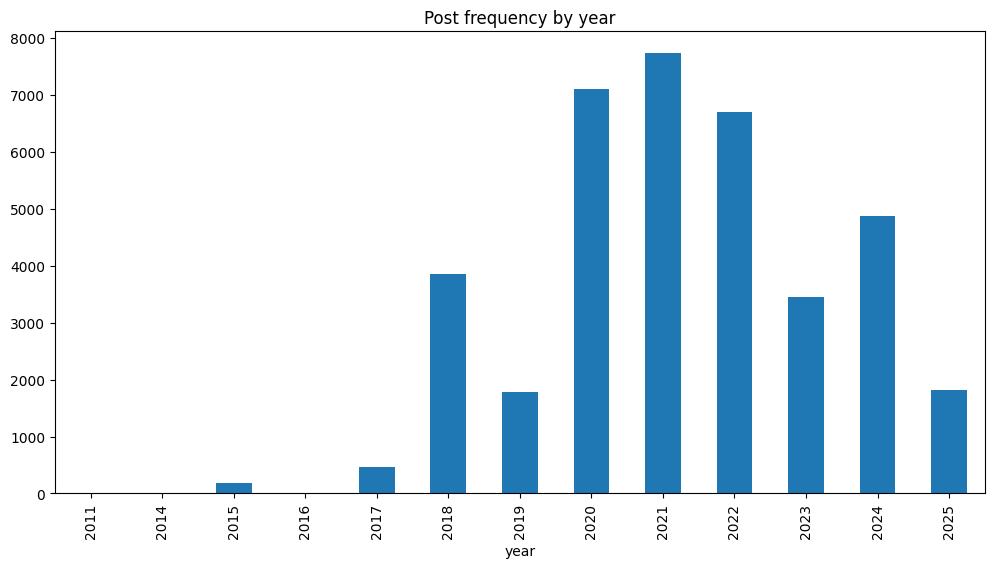

In [ ]:
# Convert to datetime if not already
processed_data['post_created_utc'] = pd.to_datetime(processed_data['post_created_utc'])

# Posts per month
processed_data['year'] = processed_data['post_created_utc'].dt.to_period('Y')
processed_data['year'].value_counts().sort_index().plot(kind='bar', figsize=(12,6), title="Post frequency by year")

 Comment Length Stats:
count       37770
unique      32427
top       deleted
freq         1208
Name: normalized_comment, dtype: object


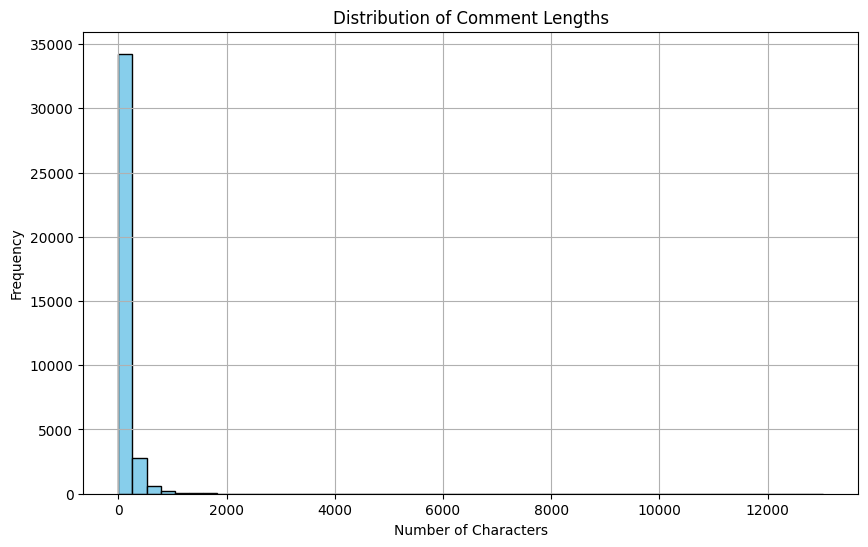

In [ ]:
processed_data['normalized_comment'] = processed_data['normalized_comment'].apply(len)

print(" Comment Length Stats:")
print(cleaned_ev_data['normalized_comment'].describe())


plt.figure(figsize=(10,6))
plt.hist(processed_data['normalized_comment'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Comment Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

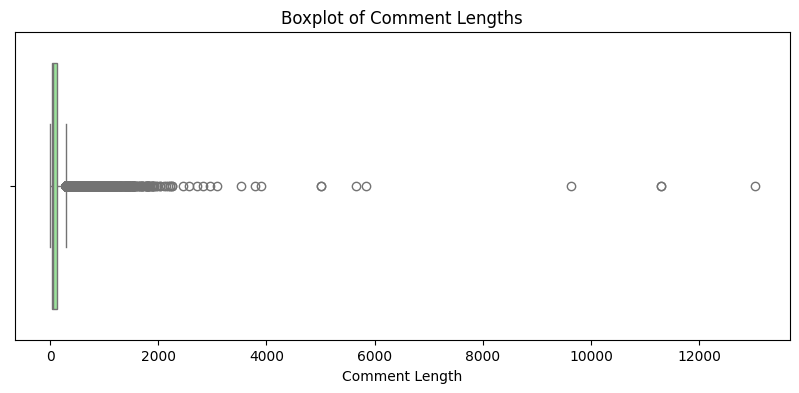

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(x=processed_data['normalized_comment'], color='lightgreen')
plt.title('Boxplot of Comment Lengths')
plt.xlabel('Comment Length')
plt.show()

In [ ]:
print("📏 Longest comment:")
print(processed_data.loc[processed_data['normalized_comment'].idxmax(), 'normalized_comment'])

print("\n📏 Shortest comment:")
print(processed_data.loc[processed_data['normalized_comment'].idxmin(), 'normalized_comment'])

📏 Longest comment:
zoo negara open Edit thinking who tking care animal wanting visit

📏 Shortest comment:
AA


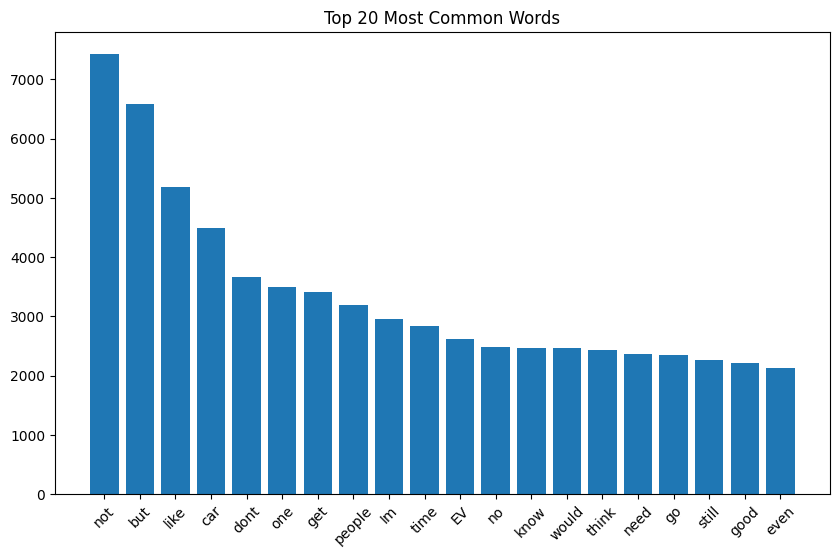

In [ ]:
# Most Common word in comment

from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all text
all_words = ' '.join(processed_data['normalized_comment'].dropna().astype(str))


# Count
word_freq = Counter(all_words.split())

# Plot top 20
most_common_words = word_freq.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10,6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words')
plt.show()

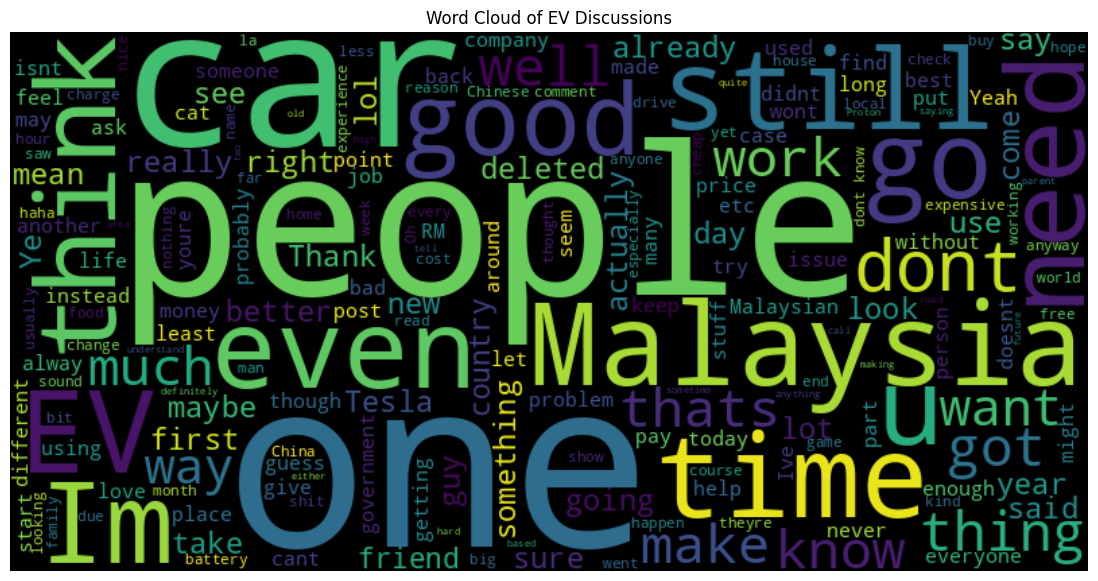

In [ ]:
wc = WordCloud(width=800, height=400, background_color='black').generate(all_words)
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of EV Discussions')
plt.show()

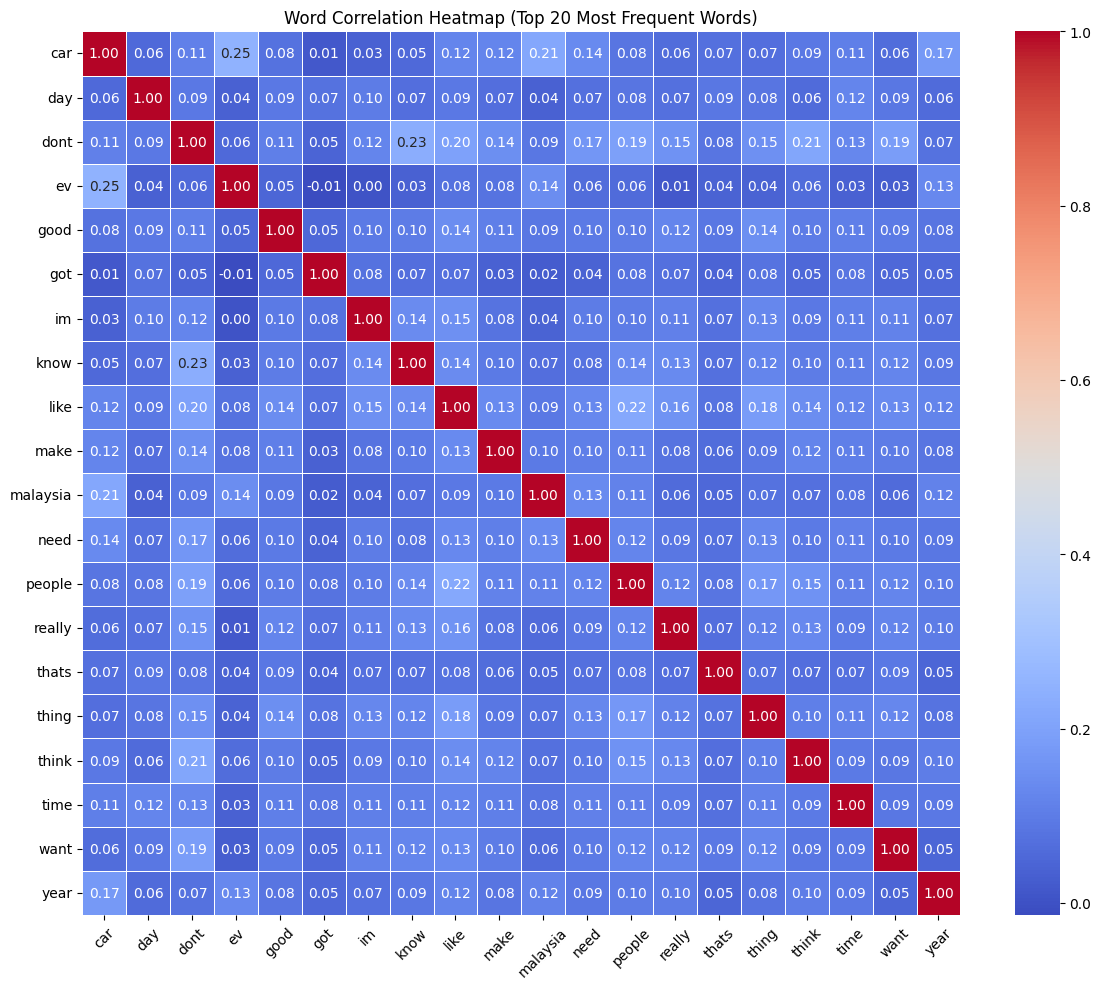

In [ ]:
# Vectorize the text using top 20 words
vectorizer = CountVectorizer(max_features=20, stop_words='english')
X = vectorizer.fit_transform(processed_data['normalized_comment'].astype(str))

# Convert to DataFrame
word_matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Compute correlation matrix
correlation_matrix = word_matrix.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Word Correlation Heatmap (Top 20 Most Frequent Words)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# random_ev_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Research_data/recleaned_ev_sentiment_data.csv')
# random_ev_data.head()

,post_id,title,selftext,post_score,upvote_ratio,num_comments,post_created_utc,comment_id,comment_body,comment_score,comment_awards,comment_created_utc,cleaned_title,cleaned_selftext,cleaned_comment,normalized_title,normalized_selftext,normalized_comment
0,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8se6pf,EV owners when they find an unattended electri...,546,0,2023-02-17 00:53:23+08:00,What are your thoughts on EV owners using publ...,NaN,EV owners when they find an unattended electri...,thought EV owner using public electrical point...,NaN,EV owner find unattended electrical outlet
1,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8twbf7,Apparently some electric cars have battery cap...,211,0,2023-02-17 06:31:30+08:00,What are your thoughts on EV owners using publ...,NaN,Apparently some electric cars have battery cap...,thought EV owner using public electrical point...,NaN,Apparently electric car battery capacity kWh p...
2,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8uhyyh,Imagine if I set up a bitcoin mining rig here....,127,0,2023-02-17 09:02:42+08:00,What are your thoughts on EV owners using publ...,NaN,Imagine if I set up a bitcoin mining rig here ...,thought EV owner using public electrical point...,NaN,Imagine set bitcoin mining rig sudden tapping ...
3,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8s4nfc,That's gonna be one really slow charge. Probab...,383,0,2023-02-16 23:50:51+08:00,What are your thoughts on EV owners using publ...,NaN,Thats gonna be one really slow charge Probably...,thought EV owner using public electrical point...,NaN,Thats gonna one really slow charge Probably ta...
4,113tako,What are your thoughts on EV owners using publ...,NaN,785,0.97,365,2023-02-16 23:32:12+08:00,j8sn4cg,It’s amazing how many people here feel that it...,253,0,2023-02-17 01:50:25+08:00,What are your thoughts on EV owners using publ...,NaN,Its amazing how many people here feel that its...,thought EV owner using public electrical point...,NaN,amazing many people feel totally ok charge car...


In [ ]:
# import pandas as pd
# sampled = random_ev_data[['normalized_comment']].sample(n=200, random_state=72)
# path = '/content/drive/MyDrive/Colab_Notebooks/Research_data/normalized_comment_sampled.xlsx'
# sampled.to_excel(path, index=False)
# print("Saved to:", path)

Saved to: /content/drive/MyDrive/Colab_Notebooks/Research_data/normalized_comment_sampled.xlsx


# Auto Sentiment Labelling

In [ ]:
processed_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Research_data/recleaned_ev_sentiment_data.csv')

labelled_data = processed_data[['normalized_comment']].copy()
labelled_data.head()

,normalized_comment
0,EV owner find unattended electrical outlet
1,Apparently electric car battery capacity kWh p...
2,Imagine set bitcoin mining rig sudden tapping ...
3,Thats gonna one really slow charge Probably ta...
4,amazing many people feel totally ok charge car...


## Vader

In [ ]:
vader = SentimentIntensityAnalyzer()


def vader_label(text):
    score = vader.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

labelled_data['vader_sentiment'] = labelled_data['normalized_comment'].apply(vader_label)

In [ ]:
labelled_data[['normalized_comment','vader_sentiment']]

,normalized_comment,vader_sentiment
0,EV owner find unattended electrical outlet,neutral
1,Apparently electric car battery capacity kWh p...,negative
2,Imagine set bitcoin mining rig sudden tapping ...,negative
3,Thats gonna one really slow charge Probably ta...,neutral
4,amazing many people feel totally ok charge car...,positive
...,...,...
38004,Yess make EV affordable,neutral
38005,spent load buy battery UPS overloadings due ex...,negative
38006,highly doubt affordable anyone outside not buy...,negative
38007,Hi doubt blackout followed power surge arent f...,neutral


In [ ]:
vader_count = labelled_data['vader_sentiment'].value_counts()
vader_count

,count
vader_sentiment,
positive,17184
neutral,11475
negative,9350


## Transformer Sentiment Pipeline

In [ ]:
# Load the sentiment analysis pipeline with the chosen model on GPU if available
transformer_sentiment = pipeline(
    "sentiment-analysis",
    model="siebert/sentiment-roberta-large-english",
    device=0  # Use GPU (cuda:0); set to -1 for CPU
)

# Helper function to map raw model labels to standardized format
def map_sentiment_label(label):
    label = label.lower()
    if label == 'positive':
        return 'Positive'
    elif label == 'negative':
        return 'Negative'
    else:
        return 'Neutral'  # fallback (Siebert is binary: pos/neg)

# Prepare text list (truncate to 512 tokens per item if needed)
texts = labelled_data['normalized_comment'].astype(str).tolist()
texts = [text[:512] for text in texts]

# Batch inference
results = transformer_sentiment(texts, batch_size=32, truncation=True)

# Map results to labels
labelled_data['bert_sentiment'] = [map_sentiment_label(res['label']) for res in results]

Device set to use cuda:0


In [ ]:
bert_counts = labelled_data['bert_sentiment'].value_counts()
bert_counts

,count
bert_sentiment,
Negative,20520
Positive,17489


In [ ]:
labelled_data[['normalized_comment','vader_sentiment', 'bert_sentiment','textblob_sentiment']]

,normalized_comment,vader_sentiment,bert_sentiment,textblob_sentiment
0,EV owner find unattended electrical outlet,neutral,Negative,Neutral
1,Apparently electric car battery capacity kWh p...,negative,Negative,Negative
2,Imagine set bitcoin mining rig sudden tapping ...,negative,Negative,Positive
3,Thats gonna one really slow charge Probably ta...,neutral,Negative,Negative
4,amazing many people feel totally ok charge car...,positive,Positive,Positive
...,...,...,...,...
38004,Yess make EV affordable,neutral,Positive,Neutral
38005,spent load buy battery UPS overloadings due ex...,negative,Negative,Negative
38006,highly doubt affordable anyone outside not buy...,negative,Positive,Negative
38007,Hi doubt blackout followed power surge arent f...,neutral,Negative,Positive


In [ ]:
# Define the path where you want to save the file
save_path = '/content/drive/MyDrive/Colab_Notebooks/Research_data/labeled_ev_sentiment_data.csv'

# Save the DataFrame to CSV
labelled_data.to_csv(save_path, index=False)

print(f"File saved to: {save_path}")

File saved to: /content/drive/MyDrive/Colab_Notebooks/Research_data/labeled_ev_sentiment_data.csv


In [ ]:
file_path = '/content/drive/MyDrive/Colab_Notebooks/Research_data/labeled_ev_sentiment_data.csv'
labelled_data = pd.read_csv(file_path)
labelled_data

,normalized_comment,vader_sentiment,bert_sentiment
0,EV owner find unattended electrical outlet,neutral,Negative
1,Apparently electric car battery capacity kWh p...,negative,Negative
2,Imagine set bitcoin mining rig sudden tapping ...,negative,Negative
3,Thats gonna one really slow charge Probably ta...,neutral,Negative
4,amazing many people feel totally ok charge car...,positive,Positive
...,...,...,...
38004,Yess make EV affordable,neutral,Positive
38005,spent load buy battery UPS overloadings due ex...,negative,Negative
38006,highly doubt affordable anyone outside not buy...,negative,Positive
38007,Hi doubt blackout followed power surge arent f...,neutral,Negative


In [ ]:
def textblob_label(text):
    try:
        polarity = TextBlob(str(text)).sentiment.polarity
        if polarity > 0:
            return 'Positive'
        elif polarity < 0:
            return 'Negative'
        else:
            return 'Neutral'
    except:
        return 'Neutral'

# Apply sentiment analysis to the normalized comment
labelled_data['textblob_sentiment'] = labelled_data['normalized_comment'].apply(textblob_label)

In [ ]:
textblob_count = labelled_data['textblob_sentiment'].value_counts()
textblob_count

,count
textblob_sentiment,
Positive,16598
Neutral,13545
Negative,7866


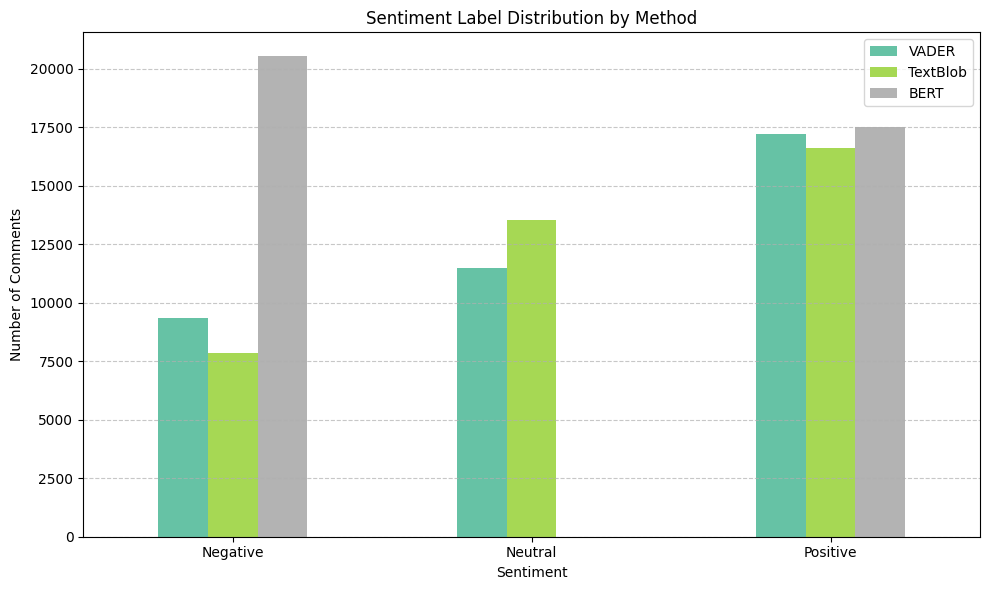

In [ ]:
# Standardize label casing to ensure consistency
labelled_data['vader_sentiment'] = labelled_data['vader_sentiment'].str.capitalize()
labelled_data['textblob_sentiment'] = labelled_data['textblob_sentiment'].str.capitalize()
labelled_data['bert_sentiment'] = labelled_data['bert_sentiment'].str.capitalize()

# Count sentiment label frequencies
vader_count = labelled_data['vader_sentiment'].value_counts()
textblob_count = labelled_data['textblob_sentiment'].value_counts()
bert_counts = labelled_data['bert_sentiment'].value_counts()

# Combine into a single DataFrame for plotting
sentiment_df = (
    pd.DataFrame({
        'VADER': vader_count,
        'TextBlob': textblob_count,
        'BERT': bert_counts
    })
    .fillna(0)
    .astype(int)
    .sort_index()
)

# Plotting
sentiment_df.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title("Sentiment Label Distribution by Method")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Save the updated DataFrame back to the same file or a new one
updated_path = '/content/drive/MyDrive/Colab_Notebooks/Research_data/labeled_ev_sentiment_data.csv'
labelled_data.to_csv(updated_path, index=False)

print(f"✅ Updated file saved to: {updated_path}")

✅ Updated file saved to: /content/drive/MyDrive/Colab_Notebooks/Research_data/labeled_ev_sentiment_data.csv


In [ ]:
# sampled = labelled_data[['normalized_comment', 'vader_sentiment', 'textblob_sentiment', 'bert_sentiment']].head(400).copy()

# output_path = '/content/drive/MyDrive/Colab_Notebooks/Research_data/normalized_comment_sampled.xlsx'
# sampled.to_excel(output_path, index=False)

# print("Saved to:", output_path)

Saved to: /content/drive/MyDrive/Colab_Notebooks/Research_data/normalized_comment_sampled.xlsx


comparison of the 3 method labelling with llm

In [ ]:
# import pandas as pd
# from sklearn.metrics import accuracy_score, classification_report

# # Load the Excel file with LLM sentiment added
# sampled = pd.read_excel('/content/drive/MyDrive/Colab_Notebooks/Research_data/normalized_comment_sampled.xlsx')

# # Ensure all columns are string type and standardized (capitalize first letter for consistency)
# for col in ['vader_sentiment', 'textblob_sentiment', 'bert_sentiment', 'llm_sentiment']:
#     sampled[col] = sampled[col].astype(str).str.capitalize().str.strip()

# # Compare accuracy of each method with LLM-labeled sentiment
# vader_acc = accuracy_score(sampled['llm_sentiment'], sampled['vader_sentiment'])
# textblob_acc = accuracy_score(sampled['llm_sentiment'], sampled['textblob_sentiment'])
# bert_acc = accuracy_score(sampled['llm_sentiment'], sampled['bert_sentiment'])

# # Print comparison
# print(f"Accuracy Comparison (vs LLM label):")
# print(f"VADER Accuracy:     {vader_acc:.4f}")
# print(f"TextBlob Accuracy:  {textblob_acc:.4f}")
# print(f"BERT Accuracy:      {bert_acc:.4f}")

# # Optional: Detailed classification report for each
# print("\n--- Classification Report for BERT ---")
# print(classification_report(sampled['llm_sentiment'], sampled['bert_sentiment']))

# print("\n--- Classification Report for VADER ---")
# print(classification_report(sampled['llm_sentiment'], sampled['vader_sentiment']))

# print("\n--- Classification Report for TextBlob ---")
# print(classification_report(sampled['llm_sentiment'], sampled['textblob_sentiment']))

Accuracy Comparison (vs LLM label):
VADER Accuracy:     0.4275
TextBlob Accuracy:  0.4025
BERT Accuracy:      0.4750

--- Classification Report for BERT ---
              precision    recall  f1-score   support

    Negative       0.59      0.86      0.70       185
     Neutral       0.00      0.00      0.00       170
    Positive       0.24      0.67      0.35        45

    accuracy                           0.47       400
   macro avg       0.27      0.51      0.35       400
weighted avg       0.30      0.47      0.36       400


--- Classification Report for VADER ---
              precision    recall  f1-score   support

    Negative       0.62      0.43      0.51       185
     Neutral       0.59      0.38      0.46       170
    Positive       0.16      0.58      0.25        45

    accuracy                           0.43       400
   macro avg       0.45      0.46      0.41       400
weighted avg       0.55      0.43      0.46       400


--- Classification Report for TextBlob 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Train Test Split

In [ ]:
data_path = "/content/drive/MyDrive/Modified_Templates/Copy of labeled_ev_sentiment_data.csv"
labelled_data = pd.read_csv(data_path)
labelled_data

,normalized_comment,vader_sentiment,bert_sentiment,textblob_sentiment
0,EV owner find unattended electrical outlet,Neutral,Negative,Neutral
1,Apparently electric car battery capacity kWh p...,Negative,Negative,Negative
2,Imagine set bitcoin mining rig sudden tapping ...,Negative,Negative,Positive
3,Thats gonna one really slow charge Probably ta...,Neutral,Negative,Negative
4,amazing many people feel totally ok charge car...,Positive,Positive,Positive
...,...,...,...,...
38004,Yess make EV affordable,Neutral,Positive,Neutral
38005,spent load buy battery UPS overloadings due ex...,Negative,Negative,Negative
38006,highly doubt affordable anyone outside not buy...,Negative,Positive,Negative
38007,Hi doubt blackout followed power surge arent f...,Neutral,Negative,Positive


In [ ]:
labelled_data = labelled_data[['normalized_comment', 'vader_sentiment']].copy()
labelled_data.head()

,normalized_comment,vader_sentiment
0,EV owner find unattended electrical outlet,Neutral
1,Apparently electric car battery capacity kWh p...,Negative
2,Imagine set bitcoin mining rig sudden tapping ...,Negative
3,Thats gonna one really slow charge Probably ta...,Neutral
4,amazing many people feel totally ok charge car...,Positive


In [ ]:
# Prepare and Encode Labels
labelled_data = labelled_data[labelled_data['vader_sentiment'].notna()].copy()
labelled_data['label'] = labelled_data['vader_sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})
labelled_data = labelled_data[labelled_data['normalized_comment'].notna() & (labelled_data['normalized_comment'].str.strip() != '')].copy()

# Stratified Train-Test Split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(labelled_data['normalized_comment'], labelled_data['label']):
    train_df = labelled_data.iloc[train_idx]
    test_df = labelled_data.iloc[test_idx]


In [ ]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (30407, 3)
Test shape: (7602, 3)


In [ ]:
train_df

,normalized_comment,vader_sentiment,label
13872,Pros instant torque fun car quiet good deal li...,Positive,2
34855,PSA SUPPORT SMALL LOCAL BUSINESSES ALWAYS TRY ...,Positive,2
17358,also sell complete ready use one,Positive,2
6784,Im always wondering government doesnt push ele...,Neutral,1
29468,thats youre canonically male Pokemon Crystal w...,Negative,0
...,...,...,...
21697,Ohh thanks,Positive,2
33184,butterfly even jeez nature spooky,Neutral,1
19120,sense pinyin know ABCs alright great autocorre...,Positive,2
26327,rmalaysia daily random discussion quick questi...,Positive,2


## Tokenization and Convert to TensorFlow Dataset

In [ ]:
import pyarrow as pa
from datasets import Value

# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(example):
    return tokenizer(example["normalized_comment"], truncation=True, max_length=256)

train_dataset = Dataset.from_pandas(train_df[["normalized_comment", "label"]])
test_dataset = Dataset.from_pandas(test_df[["normalized_comment", "label"]])

train_dataset = train_dataset.map(tokenize)
test_dataset = test_dataset.map(tokenize)

train_dataset = train_dataset.cast_column("label", Value("int32"))
test_dataset = test_dataset.cast_column("label", Value("int32"))

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/30407 [00:00<?, ? examples/s]

Map:   0%|          | 0/7602 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/30407 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7602 [00:00<?, ? examples/s]

In [ ]:
# Convert to TensorFlow Dataset
tf_train_dataset = train_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=True,
    batch_size=8,
    collate_fn=data_collator,
)

tf_eval_dataset = test_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=False,
    batch_size=8,
    collate_fn=data_collator,
)

# Model Training

## Bert-based Uncased

In [ ]:
model = TFBertForSequenceClassification.from_pretrained(, from_pt=True)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import tensorflow as tf

# Load BERT Model

# Optimizer and Callbacks (Checkpointing & Early Stopping)
batch_size = 8
epochs = 5
steps_per_epoch = len(tf_train_dataset)

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=steps_per_epoch * epochs,
    num_warmup_steps=0
)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Directory for saving all checkpoints
checkpoint_dir = "/content/drive/MyDrive/Modified_Templates/bert_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "bert_epoch_{epoch:02d}_valacc_{val_accuracy:.4f}.keras"),
    save_weights_only=False,
    save_best_only=False,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 9. Train the Model
history = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    epochs=epochs,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/5
3801/3801 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.8388
Epoch 1: saving model to /content/drive/MyDrive/Colab_Notebooks/Research_data/bert_checkpoints/bert_epoch_01_valacc_0.9132.keras


/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


3801/3801 [==============================] - 709s 176ms/step - loss: 0.4273 - accuracy: 0.8388 - val_loss: 0.2632 - val_accuracy: 0.9132
Epoch 2/5
3801/3801 [==============================] - ETA: 0s - loss: 0.1931 - accuracy: 0.9371
Epoch 2: saving model to /content/drive/MyDrive/Colab_Notebooks/Research_data/bert_checkpoints/bert_epoch_02_valacc_0.9259.keras
3801/3801 [==============================] - 642s 169ms/step - loss: 0.1931 - accuracy: 0.9371 - val_loss: 0.2380 - val_accuracy: 0.9259
Epoch 3/5
3801/3801 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.9663
Epoch 3: saving model to /content/drive/MyDrive/Colab_Notebooks/Research_data/bert_checkpoints/bert_epoch_03_valacc_0.9282.keras
3801/3801 [==============================] - 643s 169ms/step - loss: 0.1089 - accuracy: 0.9663 - val_loss: 0.2472 - val_accuracy: 0.9282
Epoch 4/5
3801/3801 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9802
Epoch 4: saving model to /content/drive/

# Model Evaluation (Bert-based Uncased)

951/951 [==============================] - 62s 56ms/step

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      1870
     Neutral       0.92      0.94      0.93      2295
    Positive       0.95      0.94      0.95      3437

    accuracy                           0.93      7602
   macro avg       0.93      0.93      0.93      7602
weighted avg       0.93      0.93      0.93      7602



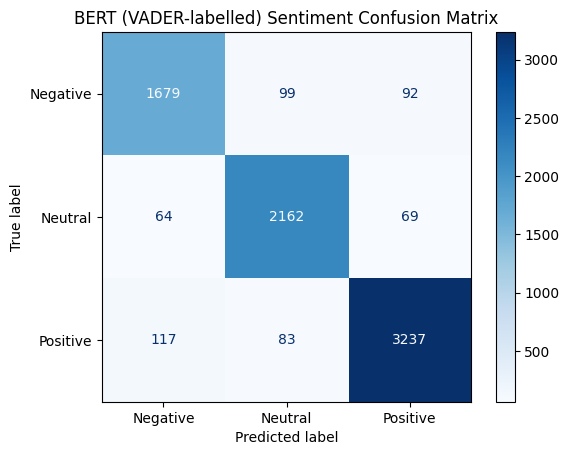

In [ ]:
# 10. Evaluate the Model
y_true = list(test_df['label'])
y_pred_logits = model.predict(tf_eval_dataset).logits
y_pred = tf.math.argmax(y_pred_logits, axis=1).numpy()

# 11. Decode labels back to string
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
y_true_labels = [label_map[label] for label in y_true]
y_pred_labels = [label_map[label] for label in y_pred]

# 12. Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels))

# 13. Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=["Negative", "Neutral", "Positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap="Blues")
plt.title("BERT (VADER-labelled) Sentiment Confusion Matrix")
plt.show()


## RoBERTa

In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

In [ ]:
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(example):
    return roberta_tokenizer(example["normalized_comment"], truncation=True, max_length=256)

train_dataset = Dataset.from_pandas(train_df[["normalized_comment", "label"]])
test_dataset = Dataset.from_pandas(test_df[["normalized_comment", "label"]])

train_dataset = train_dataset.map(tokenize)
test_dataset = test_dataset.map(tokenize)

train_dataset = train_dataset.cast_column("label", Value("int32"))
test_dataset = test_dataset.cast_column("label", Value("int32"))

data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer, return_tensors="tf")

Map:   0%|          | 0/30407 [00:00<?, ? examples/s]

Map:   0%|          | 0/7602 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/30407 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7602 [00:00<?, ? examples/s]

In [ ]:
# Convert to TensorFlow Dataset
batch_size = 8
tf_train_dataset = train_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_eval_dataset = test_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [ ]:
# 7. Load RoBERTa Model
roberta_model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
import os
from transformers import (
    TFRobertaForSequenceClassification,
    RobertaTokenizer,
    create_optimizer
)
import tensorflow as tf

# Prepare optimizer and learning rate schedule
epochs = 5
steps_per_epoch = len(tf_train_dataset)

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=steps_per_epoch * epochs,
    num_warmup_steps=int(0.1 * steps_per_epoch * epochs)  # optional warmup
)

# Compile model
roberta_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Prepare callbacks

# Checkpoint weights only
checkpoint_dir = "/content/drive/MyDrive/Modified_Templates/roberta_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_weights.h5"),
    save_weights_only=True,        # <--- Important!
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

#  Train
history = roberta_model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    epochs=epochs,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/5
3801/3801 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.7618
Epoch 1: val_accuracy improved from -inf to 0.87530, saving model to /content/drive/MyDrive/Modified_Templates/roberta_checkpoints/best_weights.h5
3801/3801 [==============================] - 730s 182ms/step - loss: 0.5696 - accuracy: 0.7618 - val_loss: 0.3600 - val_accuracy: 0.8753
Epoch 2/5
3801/3801 [==============================] - ETA: 0s - loss: 0.3006 - accuracy: 0.8979
Epoch 2: val_accuracy improved from 0.87530 to 0.89700, saving model to /content/drive/MyDrive/Modified_Templates/roberta_checkpoints/best_weights.h5
3801/3801 [==============================] - 657s 173ms/step - loss: 0.3006 - accuracy: 0.8979 - val_loss: 0.3039 - val_accuracy: 0.8970
Epoch 3/5
3801/3801 [==============================] - ETA: 0s - loss: 0.2001 - accuracy: 0.9347
Epoch 3: val_accuracy improved from 0.89700 to 0.91239, saving model to /content/drive/MyDrive/Modified_Templates/roberta_checkpoints/best

In [ ]:
save_dir = "/content/drive/MyDrive/Modified_Templates"
model.save_pretrained(save_dir)


('/content/drive/MyDrive/Modified_Templates/tokenizer_config.json',
 '/content/drive/MyDrive/Modified_Templates/special_tokens_map.json',
 '/content/drive/MyDrive/Modified_Templates/vocab.json',
 '/content/drive/MyDrive/Modified_Templates/merges.txt',
 '/content/drive/MyDrive/Modified_Templates/added_tokens.json')

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Modified_Templates/best_roberta")

In [ ]:
tokenizer.save_pretrained("/content/drive/MyDrive/Modified_Templates/tokenizer")

('/content/drive/MyDrive/Modified_Templates/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Modified_Templates/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Modified_Templates/tokenizer/vocab.json',
 '/content/drive/MyDrive/Modified_Templates/tokenizer/merges.txt',
 '/content/drive/MyDrive/Modified_Templates/tokenizer/added_tokens.json')

# Model Evaluation (RoBERTa)

In [ ]:
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer

# Load model
model_1 = TFRobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/Modified_Templates/best_roberta')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Modified_Templates/best_roberta.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


951/951 [==============================] - 65s 59ms/step

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.88      0.91      0.89      1870
     Neutral       0.95      0.92      0.94      2295
    Positive       0.93      0.94      0.93      3437

    accuracy                           0.92      7602
   macro avg       0.92      0.92      0.92      7602
weighted avg       0.92      0.92      0.92      7602



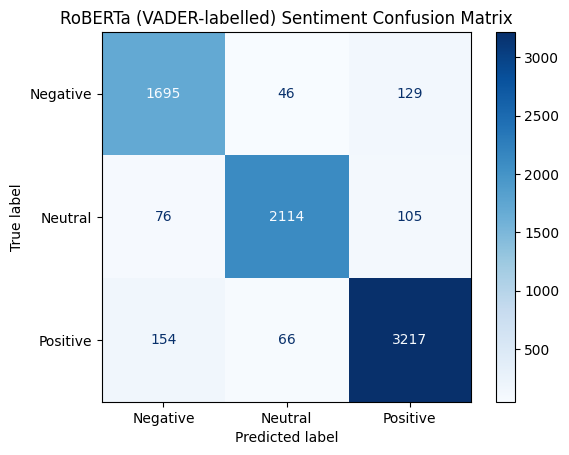

In [ ]:
# 10. Evaluate the RoBERTa Model
y_true = list(test_df['label'])
y_pred_logits = roberta_model.predict(tf_eval_dataset).logits
y_pred = tf.math.argmax(y_pred_logits, axis=1).numpy()


# 11. Decode labels back to string
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
y_true_labels = [label_map[label] for label in y_true]
y_pred_labels = [label_map[label] for label in y_pred]


# 12. Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels))


# 13. Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=["Negative", "Neutral", "Positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap="Blues")
plt.title("RoBERTa (VADER-labelled) Sentiment Confusion Matrix")
plt.show()

In [ ]:
# from transformers import TFRobertaForSequenceClassification, RobertaTokenizer, create_optimizer
# import tensorflow as tf
# import os

# # Create dummy data
# texts = ["I love this!", "I hate this!", "This is amazing.", "Terrible experience."]
# labels = [1, 0, 1, 0]

# tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
# encodings = tokenizer(
#     texts,
#     truncation=True,
#     padding=True,
#     max_length=16,
#     return_tensors="tf"
# )

# dataset = tf.data.Dataset.from_tensor_slices((
#     dict(encodings),
#     labels
# )).batch(2)

# # Initialize model
# model = TFRobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# # Optimizer
# optimizer, schedule = create_optimizer(
#     init_lr=2e-5,
#     num_train_steps=10,
#     num_warmup_steps=0
# )

# model.compile(
#     optimizer=optimizer,
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy']
# )

# # Train briefly
# model.fit(dataset, epochs=1)

# # Save correctly
# save_dir = "/content/roberta_final_model"
# model.save_pretrained(save_dir)
# tokenizer.save_pretrained(save_dir)

# # Clear model
# del model

# # Load again
# model = TFRobertaForSequenceClassification.from_pretrained(save_dir)
# tokenizer = RobertaTokenizer.from_pretrained(save_dir)

# # Inference test
# inputs = tokenizer("I love it", return_tensors="tf")
# outputs = model(**inputs)
# print(outputs.logits)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

2/2 [==============================] - 47s 167ms/step - loss: 0.6941 - accuracy: 0.5000


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /content/roberta_final_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


tf.Tensor([[0.17744038 0.06247956]], shape=(1, 2), dtype=float32)
